<a href="https://colab.research.google.com/github/PradiptaBehera8558/B.Tech-Major-Project-2019-2023/blob/main/Doge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
pip install fitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import numpy as np
import pandas as pd
import math
from scipy import stats
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from scipy.stats.mstats import winsorize
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron as ppca
from tabulate import tabulate
from arch import arch_model
import arch
from ta import trend
from ta import volatility
import matplotlib.pyplot as plt

In [9]:
data = pd.read_excel('gdrive/MyDrive/project/Major Project/Final Data Set/Dogecoin DOGE.xlsx')
data.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,2023-02-15,0.08353,0.08935,0.08283,0.08929,846713153,11846290891
1,2023-02-14,0.08214,0.08365,0.08127,0.08353,427664094,11082535446
2,2023-02-13,0.08214,0.08620,0.07998,0.08216,752090969,10899636149
3,2023-02-12,0.08235,0.08542,0.08174,0.08214,448723137,10898077867
4,2023-02-11,0.08107,0.08251,0.08079,0.08237,244141279,10928347807


In [10]:
col_name = ['Date','Open','High','Low','Close','Volume','MarketCapita']
data.columns = col_name
def clean_columns(col):
    col = col.astype(str)
    if col.name.lower().startswith('date'):
        return pd.to_datetime(col)
    return pd.to_numeric(col.str.replace(',', '').str.replace('$', ''), errors='coerce')
data = data.apply(clean_columns)
data = data.set_index('Date')

<ipython-input-10-a91d3682f4c5>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  return pd.to_numeric(col.str.replace(',', '').str.replace('$', ''), errors='coerce')


In [11]:
data['Daily_Return'] = data['Close'].pct_change()
data['Daily_Volumetric_Change'] = data['Volume'].pct_change()
data = data.iloc[1:]

In [12]:
iqr = data.quantile(0.75) - data.quantile(0.25)
print("Descriptive Statistics of the Dataset is given below: ")
stats = pd.concat([data.describe().T,
                data.mad().to_frame('MAD'),
                data.skew().to_frame('Skew'),
                data.kurtosis().to_frame('Kurtosis'),
                data.sem().to_frame('SEM'),
                iqr.to_frame('IQR'),
                data.var().to_frame('Variance')
            ],
              axis=1)
stats.to_excel("xrp.xlsx")

Descriptive Statistics of the Dataset is given below: 


In [13]:
print("Shape of the Collected Cardano Data : {}".format(data.shape))

Shape of the Collected Cardano Data : (3349, 8)


In [14]:
print("Datatypes of all the available columns in the dataset :\n{}".format(data.dtypes))

Datatypes of all the available columns in the dataset :
Open                       float64
High                       float64
Low                        float64
Close                      float64
Volume                       int64
MarketCapita                 int64
Daily_Return               float64
Daily_Volumetric_Change    float64
dtype: object


In [15]:
print("Count of null values present in all the available columns in the dataset :\n{}".format(data.isnull().sum()))

Count of null values present in all the available columns in the dataset :
Open                        0
High                        0
Low                         0
Close                       0
Volume                      0
MarketCapita                0
Daily_Return                0
Daily_Volumetric_Change    11
dtype: int64


In [16]:
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
iqr = q3 - q1
outliers = (data < (q1 - 1.5 * iqr)) | (data > (q3 + 1.5 * iqr))
outlier_rows = np.where(outliers.any(axis=1))[0]
print("No. of outlying rows present in the dataset : {}".format(len(outlier_rows)))

No. of outlying rows present in the dataset : 1180


In [17]:
alpha = 0.05
close_price_test = adfuller(data['Close'], autolag='AIC')

print("============================================================================================")
print('ADF Statistic: %f' % close_price_test[0])
print('p-value: %f' % close_price_test[1])
print('Critical Values:')
for key, value in close_price_test[4].items():
    print('\t%s: %.3f' % (key, value))

if close_price_test[1] < alpha:
    close_price_trend = "Stationary"
    print("The trend is {} for Daily Returns".format(close_price_trend))
    print("============================================================================================")
else:
    close_price_test = ppca(np.array(data['Close']),autolag='AIC')
    print("============================================================================================")
    print('PP Statistic: %f' % close_price_test[0])
    print('p-value: %f' % close_price_test[1])
    print('Critical Values:')
    for key, value in close_price_test[3].items():
        print('\t%s: %.3f' % (key, value))
    if close_price_test[1] < alpha:
        close_price_trend = "Stationary"
        print("The trend is {} for Daily Returns".format(close_price_trend))
        print("============================================================================================")
    else:
        close_price_trend = "Trend"
        print("The trend is {} for Daily Returns".format(close_price_trend))
        print("============================================================================================")

# Test for trend in volume
volume_test = adfuller(data['Volume'], autolag='AIC')

print("============================================================================================")
print('ADF Statistic: %f' % volume_test[0])
print('p-value: %f' % volume_test[1])
print('Critical Values:')
for key, value in volume_test[4].items():
    print('\t%s: %.3f' % (key, value))

if volume_test[1] < alpha:
    volume_trend = "Stationary"
    print("The trend is {} for Daily Volumetric Change".format(volume_trend))
    print("============================================================================================")
else:
    volume_test = ppca(np.array(data['Volume']), autolag='AIC')
    print("============================================================================================")
    print('PP Statistic: %f' % volume_test[0])
    print('p-value: %f' % volume_test[1])
    print('Critical Values:')
    for key, value in volume_test[3].items():
        print('\t%s: %.3f' % (key, value))
        
    if volume_test[1] < alpha:
        volume_trend = "Stationary"
        print("The trend is {} for Daily Volumetric Change".format(volume_trend))
        print("============================================================================================")
    else:
        volume_trend = "Trend"
        print("The trend is {} for Daily Volumetric Change".format(volume_trend))

ADF Statistic: -3.312601
p-value: 0.014325
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The trend is Stationary for Daily Returns
ADF Statistic: -6.039478
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The trend is Stationary for Daily Volumetric Change


In [18]:
"""
    -> Testing of volatility using GARCH Model    
"""
# Testing for volatility in volume change
garch_model1 = arch.arch_model(data['Volume'], vol='GARCH', p=1, q=1)
garch_result1 = garch_model1.fit(disp='off')
# Extract volatility series
vol_volatility = garch_result1.conditional_volatility
volume_std = data['Volume'].std()

# Testing for volatility in daily returns
garch_model2 = arch.arch_model(data['Close'], vol='GARCH', p=1, q=1)
garch_result2 = garch_model2.fit(disp='off')
# Extract volatility series
daily_returns_volatility = garch_result2.conditional_volatility
daily_returns_std = data['Close'].std()


# Set volatility threshold to 1.5 times standard deviation
volume_threshold = 1.5 * volume_std
if vol_volatility.max() > volume_threshold:
    print("============================================================================================")
    print('Volatility detected for Daily Volumetric Change')
    print("============================================================================================")
else:
    print("============================================================================================")
    print('No volatility detected for Daily Volumetric Change')
    print("============================================================================================")
    

daily_returns_threshold = 1.5 * daily_returns_std
if daily_returns_volatility.max() > daily_returns_threshold:
    print("============================================================================================")
    print('Volatility detected for Daily Returns')
    print("============================================================================================")
else:
    print("============================================================================================")
    print('No volatility detected for Daily Returns')
    print("============================================================================================")

Volatility detected for Daily Volumetric Change
Volatility detected for Daily Returns


/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.016e+18. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e-08 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006335. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [19]:
df = data.copy(deep=True)

================ Implementation of Moving Average Convergence Divergence (Trend Indicator) ================


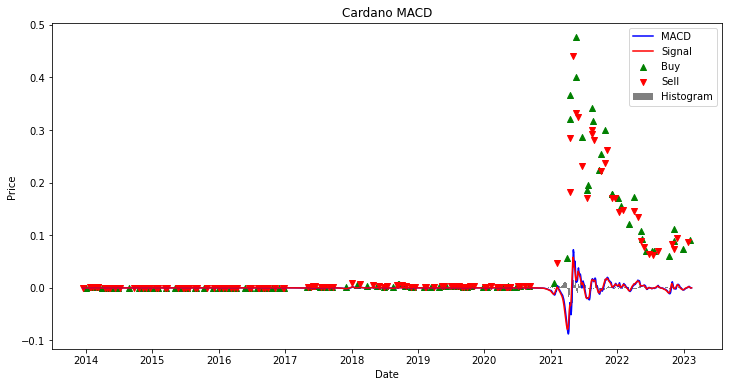

In [20]:
print("================ Implementation of Moving Average Convergence Divergence (Trend Indicator) ================")
fast_period = 12
slow_period = 26
signal_period = 9
ema_fast = data['Close'].ewm(span=fast_period, adjust=False).mean()
ema_slow = data['Close'].ewm(span=slow_period, adjust=False).mean()
macd = ema_fast - ema_slow
signal = macd.ewm(span=signal_period, adjust=False).mean()
hist = macd - signal

# Define buy and sell signals using if else conditional
data['Buy_Signal'] = np.where((macd > signal) & (macd.shift() < signal.shift()), 1, 0)
data['Sell_Signal'] = np.where((macd < signal) & (macd.shift() > signal.shift()), -1, 0)

# Plot MACD and buy/sell signals
plt.figure(figsize=(12,6))
plt.plot(data.index, macd, label='MACD', color='blue')
plt.plot(data.index, signal, label='Signal', color='red')
plt.bar(data.index, hist, label='Histogram', color='gray')
plt.scatter(data[data['Buy_Signal'] == 1].index, data[data['Buy_Signal'] == 1]['Close'], label='Buy', marker='^', color='green')
plt.scatter(data[data['Sell_Signal'] == -1].index, data[data['Sell_Signal'] == -1]['Close'], label='Sell', marker='v', color='red')
plt.legend()
plt.title('Cardano MACD')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
print("=============================================================================================================================")

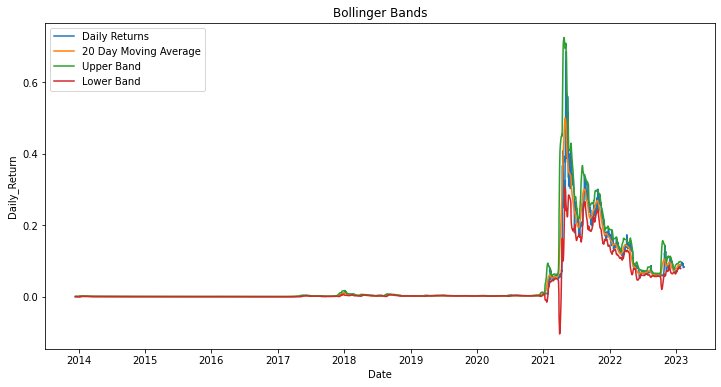

<ipython-input-21-1d775f8f0ce1>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'][i] = 1
<ipython-input-21-1d775f8f0ce1>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'][i] = -1


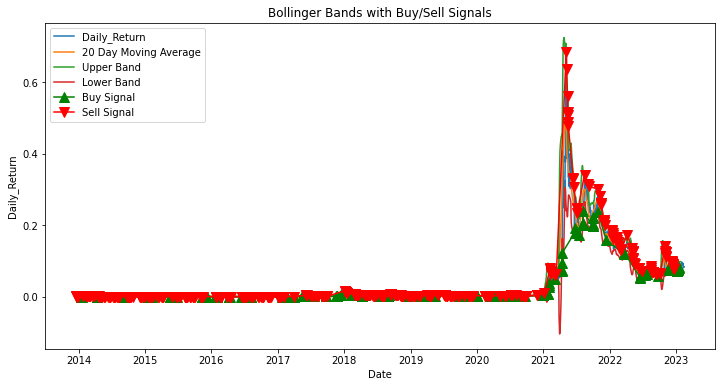

In [21]:
# Compute 20-day rolling mean and standard deviation
data['Close: 20 Day Mean'] = data['Close'].rolling(window=20).mean()
data['Close: 20 Day STD'] = data['Close'].rolling(window=20).std()

# Compute upper and lower Bollinger Bands
data['Upper Band'] = data['Close: 20 Day Mean'] + (data['Close: 20 Day STD'] * 2)
data['Lower Band'] = data['Close: 20 Day Mean'] - (data['Close: 20 Day STD'] * 2)

# Plot Bollinger Bands
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label='Daily Returns')
plt.plot(data.index, data['Close: 20 Day Mean'], label='20 Day Moving Average')
plt.plot(data.index, data['Upper Band'], label='Upper Band')
plt.plot(data.index, data['Lower Band'], label='Lower Band')
plt.fill_between(data.index, data['Lower Band'], data['Upper Band'], alpha=0.1)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Daily_Return')
plt.legend()
plt.show()

# Generate buy and sell signals
data['Position'] = None

for i in range(20, len(data)):
    if data['Close'][i] > data['Upper Band'][i-1]: # Sell signal
        data['Position'][i] = -1
    elif data['Close'][i] < data['Lower Band'][i-1]: # Buy signal
        data['Position'][i] = 1
        
# Plot buy and sell signals
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label='Daily_Return')
plt.plot(data.index, data['Close: 20 Day Mean'], label='20 Day Moving Average')
plt.plot(data.index, data['Upper Band'], label='Upper Band')
plt.plot(data.index, data['Lower Band'], label='Lower Band')
plt.fill_between(data.index, data['Lower Band'], data['Upper Band'], alpha=0.1)

# Plot buy and sell signals
plt.plot(data[data['Position'] == 1].index, data[data['Position'] == 1]['Close'], marker='^', markersize=10, color='green', label='Buy Signal')
plt.plot(data[data['Position'] == -1].index, data[data['Position'] == -1]['Close'], marker='v', markersize=10, color='red', label='Sell Signal')

plt.title('Bollinger Bands with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Daily_Return')
plt.legend()
plt.show()


This code computes the CMF indicator using the Bitcoin close price, high price, low price, and volume data. The money flow multiplier is calculated for each day, and then multiplied by the volume to obtain the money flow volume. The CMF is then calculated as the sum of the 20-day money flow volume divided by the sum of the 20-day volume.

The code then plots the CMF over time, using the plot() function from matplotlib.

Note that this is just one possible implementation of the CMF indicator, and there are many other ways to compute it. Additionally, as with any financial indicator, it's important to carefully consider the interpretation of the results and to avoid making trading decisions based solely on the indicator.

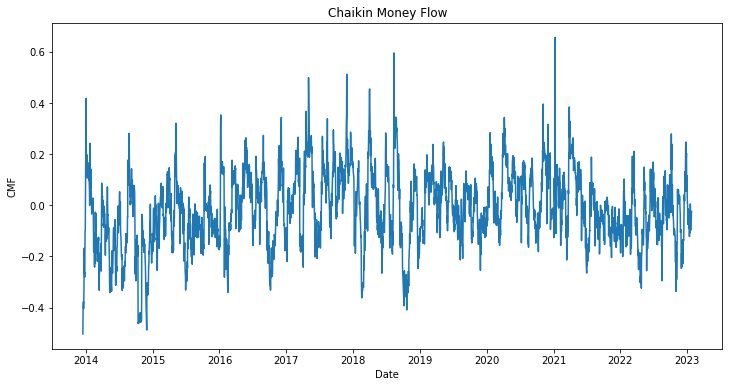

In [22]:
# Compute CMF
money_flow_multiplier = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / (data['High'] - data['Low'])
money_flow_volume = money_flow_multiplier * data['Volume']
cmf = money_flow_volume.rolling(window=20).sum() / data['Volume'].rolling(window=20).sum()

# Plot CMF
plt.figure(figsize=(12,6))
plt.plot(data.index, cmf)
plt.title('Chaikin Money Flow')
plt.xlabel('Date')
plt.ylabel('CMF')
plt.show()

This code computes the OBV indicator using the Bitcoin close price and volume data. The OBV is calculated by iterating through each day of data and checking whether the close price is higher or lower than the previous day. If it is higher, then the volume for that day is added to the OBV; if it is lower, then the volume is subtracted; and if it is the same, then the OBV stays the same.

The code then plots the OBV over time, using the plot() function from matplotlib.

Note that this is just one possible implementation of the OBV indicator, and there are many other ways to compute it. Additionally, as with any financial indicator, it's important to carefully consider the interpretation of the results and to avoid making trading decisions based solely on the indicator.

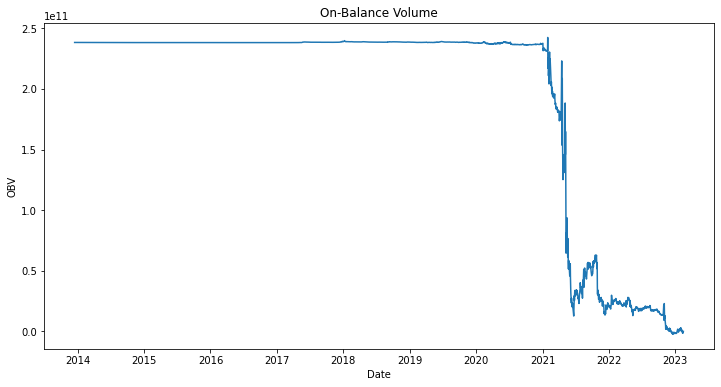

In [23]:
# Compute OBV
obv = pd.Series([0] * len(data))
for i in range(1, len(data)):
    if data['Close'][i] > data['Close'][i-1]:
        obv[i] = obv[i-1] + data['Volume'][i]
    elif data['Close'][i] < data['Close'][i-1]:
        obv[i] = obv[i-1] - data['Volume'][i]
    else:
        obv[i] = obv[i-1]

# Plot OBV
plt.figure(figsize=(12,6))
plt.plot(data.index, obv)
plt.title('On-Balance Volume')
plt.xlabel('Date')
plt.ylabel('OBV')
plt.show()

This code computes the RSI indicator using the Bitcoin close price data. The RSI is calculated by first specifying the RSI period (in this case, 14), and then calculating the change in price between each day. The code then separates the positive and negative price changes, and calculates the average gain and loss over the RSI period. Finally, the RSI is calculated as 100 - (100 / (1 + RS)), where RS is the average gain / average loss.

The code then plots the RSI over time, using the plot() function from matplotlib. Additionally, two horizontal lines are added at the 30 and 70 levels, which are commonly used as oversold and overbought thresholds, respectively.

Note that this is just one possible implementation of the RSI indicator, and there are many other ways to compute it. Additionally, as with any financial indicator, it's important to carefully consider the interpretation of the results and to avoid making trading decisions based solely on the indicator.

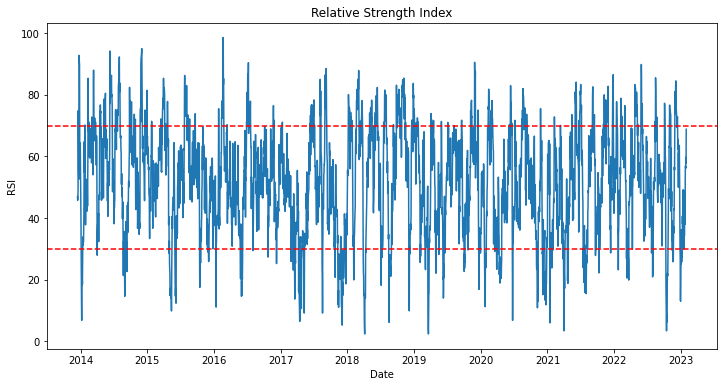

In [24]:
# Define RSI period and calculate change in price
rsi_period = 14
delta = data['Close'].diff()

# Get positive and negative price changes
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

# Calculate average gain and loss
avg_gain = up.rolling(window=rsi_period).mean()
avg_loss = abs(down.rolling(window=rsi_period).mean())

# Calculate RSI
rs = avg_gain / avg_loss
rsi = 100.0 - (100.0 / (1.0 + rs))

# Plot RSI
plt.figure(figsize=(12,6))
plt.plot(data.index, rsi)
plt.axhline(y=30, color='r', linestyle='--')
plt.axhline(y=70, color='r', linestyle='--')
plt.title('Relative Strength Index')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

This code first calculates the True Range (TR) for each day, which is the maximum of the absolute difference between the high and low prices, the absolute difference between the high price and the previous day's close price, and the absolute difference between the low price and the previous day's close price. The ATR is then calculated as the rolling mean of the TR over the ATR period (in this case, 14).

The code then plots the ATR on top of the Bitcoin volume change and daily returns data, using the twinx() function from matplotlib to create a second y-axis. This allows for better visualization of the ATR compared to the other data, which may have different scales.

Note that this is just one possible implementation of the ATR indicator, and there are many other ways to compute it. Additionally, as with any financial indicator, it's important to carefully consider the interpretation of the results and to avoid making trading decisions based solely on the indicator.

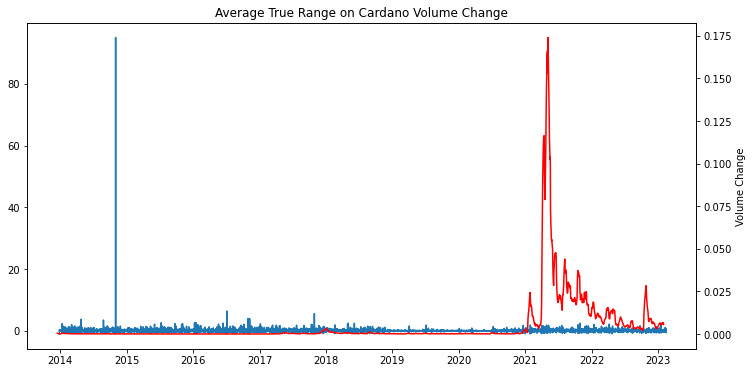

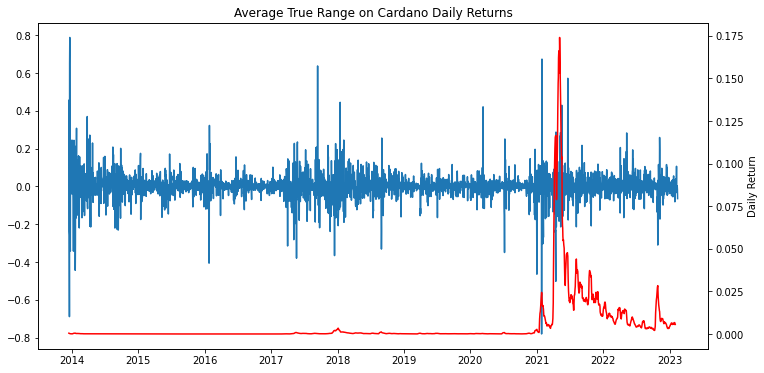

In [25]:
atr_period = 14

# Calculate True Range (TR)
data['High_Low'] = abs(data['High'] - data['Low'])
data['High_Close'] = abs(data['High'] - data['Close'].shift())
data['Low_Close'] = abs(data['Low'] - data['Close'].shift())
data['TR'] = data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)

# Calculate Average True Range (ATR)
data['ATR'] = data['TR'].rolling(window=atr_period).mean()

# Plot ATR on Volume Change
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Daily_Volumetric_Change'])
plt.twinx()
plt.plot(data.index, data['ATR'], color='r')
plt.title('Average True Range on Cardano Volume Change')
plt.xlabel('Date')
plt.ylabel('Volume Change')
plt.show()
print("===================================================================================================")
# Plot ATR on Daily Returns
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Daily_Return'])
plt.twinx()
plt.plot(data.index, data['ATR'], color='r')
plt.title('Average True Range on Cardano Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

In [26]:
from arch import arch_model
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.stats.diagnostic as smd
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

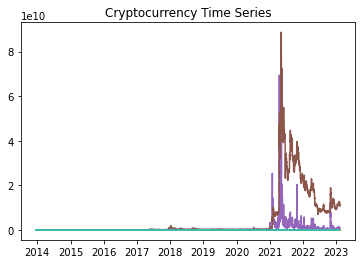

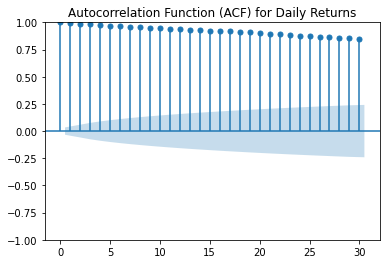

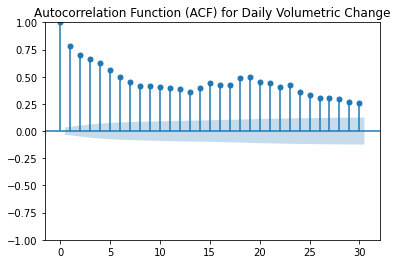

In [27]:
plt.plot(data)
plt.title('Cryptocurrency Time Series')
plt.show()
plot_acf(data['Close'], lags=30)
plt.title('Autocorrelation Function (ACF) for Daily Returns')
plt.show()
plot_acf(data['Volume'], lags=30)
plt.title('Autocorrelation Function (ACF) for Daily Volumetric Change')
plt.show()

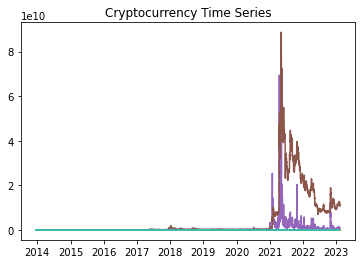

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


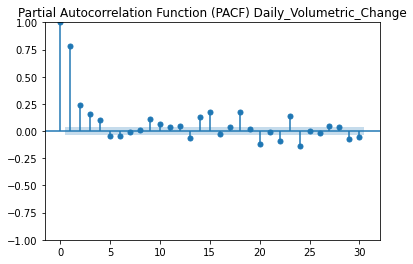

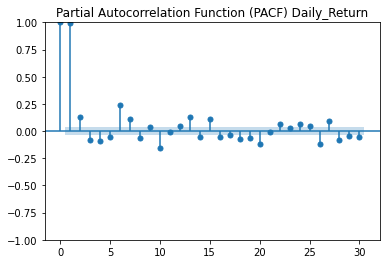

In [28]:
plt.plot(data)
plt.title('Cryptocurrency Time Series')
plt.show()
plot_pacf(data['Volume'], lags=30)
plt.title('Partial Autocorrelation Function (PACF) Daily_Volumetric_Change')
plt.show()
plot_pacf(data['Close'], lags=30)
plt.title('Partial Autocorrelation Function (PACF) Daily_Return')
plt.show()

In [29]:
from scipy.stats.mstats import winsorize
cols_to_winsorize = df.columns
df[cols_to_winsorize] = df[cols_to_winsorize].apply(lambda x: winsorize(x, limits=(0.05, 0.05)))

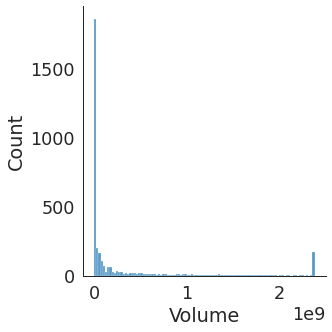

In [30]:
import seaborn as sns
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
vol_fig = sns.displot(data=df, x="Volume", kind="hist", bins = 100, aspect = 1.0)

In [31]:
DailyVolCh = df["Volume"].values
dist1 = Fitter(DailyVolCh,timeout=1000, distributions = ['vonmises_line'])
dist1.fit()

Fitting 1 distributions: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


In [32]:
trns1 = dist1.get_best()
trns1

{'vonmises_line': {'kappa': 2.642818435155,
  'loc': 186892795.20455223,
  'scale': 699375882.9549656}}

In [33]:
from scipy.stats import vonmises_line
trns1 = dist1.get_best()
#trns1 = flatten_dict(trns1)
kappa, loc, scale = trns1['vonmises_line']['kappa'], trns1['vonmises_line']['loc'], trns1['vonmises_line']['scale']
df['transVol'] = vonmises_line.cdf(DailyVolCh, kappa, loc = loc, scale = scale)

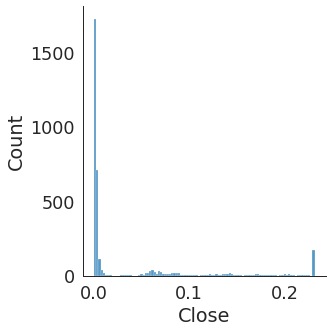

In [34]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
Daily_Return_fig = sns.displot(data=df, x="Close", kind="hist", bins = 100, aspect = 1.0)

In [35]:
DailyReturn = df["Close"].values
dist2 = Fitter(DailyReturn,timeout=1000, distributions=['johnsonsu'])
dist2.fit()

Fitting 1 distributions: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


In [36]:
trns2 = dist2.get_best()
trns2

{'johnsonsu': {'a': -3.1691798114373393,
  'b': 0.2608891962733671,
  'loc': 0.000132880278705707,
  'scale': 9.452708876324298e-09}}

In [37]:
from scipy.stats import johnsonsu
a,b, loc, scale = trns2['johnsonsu']['a'],trns2['johnsonsu']['b'], trns2['johnsonsu']['loc'], trns2['johnsonsu']['scale']
df['transDR'] = johnsonsu.cdf(DailyReturn, a,b, loc = loc, scale = scale)

In [62]:
from sklearn.model_selection import train_test_split
class ELM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_weights = np.random.normal(size=[self.input_size, self.hidden_size])
        self.bias = np.random.normal(size=[1, self.hidden_size])
        self.output_weights = None
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def fit(self, X, y):
        # Calculate the hidden layer output
        G = self.relu(np.dot(X, self.input_weights) + self.bias)
        
        # Calculate the output weights using the Moore-Penrose pseudoinverse
        self.output_weights = np.dot(np.linalg.pinv(G), y)
    
    def predict(self, X):
        # Calculate the hidden layer output
        G = self.relu(np.dot(X, self.input_weights) + self.bias)
        
        # Calculate the predicted output
        y_pred = np.dot(G, self.output_weights)
        return y_pred

X = np.array(df['transVol']).reshape(-1,1)
y = df['transDR']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2)
elm = ELM(input_size=X.shape[1], hidden_size=10, output_size=1)
results = elm.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = elm.predict(X_test)


# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
n = X.shape[0] # number of observations
k = X.shape[1] # number of predictors
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)
adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
smape = 100 / len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))
mae = mean_absolute_error(y_test, y_pred)
print("RMSE: ",rmse) 
print("R2 Score: ",r_squared) 
print("MAE: ", mae) 
print("Adjusted R-squared: ",adj_r_squared) 

RMSE:  0.12412950146813931
R2 Score:  0.7658213327248922
MAE:  0.09380458925595336
Adjusted R-squared:  0.7657513659883295


In [39]:
iqr = df.quantile(0.75) - df.quantile(0.25)
print("Descriptive Statistics of the Dataset is given below: ")
stats = pd.concat([df.describe().T,
                df.mad().to_frame('MAD'),
                df.skew().to_frame('Skew'),
                df.kurtosis().to_frame('Kurtosis'),
                df.sem().to_frame('SEM'),
                iqr.to_frame('IQR'),
                df.var().to_frame('Variance')
            ],
              axis=1)
# print(stats)
stats.to_excel("xrp1.xlsx")

Descriptive Statistics of the Dataset is given below: 
